# 8.2 Epipolar geometry

Epipolar geometry is the **set of geometric constraints between two views of a scene**. When two cameras capture a 3D scene from two different positions, there are a number of geometric relations between the 3D points and their projections onto the 2D images that lead to constraints between the image points. These relations are derived based on the assumption that the cameras can be approximated by the pinhole camera model (e.g. their images are undistorted). $\\[10pt]$

<img src="./images/epipolar.png" width="500" />$\\[10pt]$

In this notebook, we will go deeper into epipolar geometry, learning:

- Basic concepts of epipolar geometry
- Stereo rectification
- Essential matrix
- Fundamental matrix

## Problem context - Stereo rectification

In practice, as we depicted in the previous notebook, accurate triangulation is not fully feasible as **stereo systems does not fulfill the ideal configuration**, but the good news is that any two images taken with any configuration (as long as there is overlap between the images, of course) can be transformed so that they comply with an ideal stereo camera configuration. This is called **stereo rectification** or **image rectification**. Here, we apply homographies to the left and right images in order to force this ideal configuration.$\\[10pt]$

<img src="./images/rectification.png" width="600" />

Image rectification is based in epipolar geometry so, let's start to learn how it works!

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

images_path = './images/'

import sys
sys.path.append("..")
from utils.drawlines import drawlines

## 8.2.1 Concepts of epipolar geometry

Before starting to explain how epipolar geometry works, we have to understand some basic concepts: the **epipolar plane**, the **epipolar lines** and the **epipoles**.

First of all, we have the **epipolar plane**. This plane is formed by 3 points: the left and right optical centers ($C_l,\ C_r$), and a 3D point in the world ($\mathbf{X}$). 

<img src="./images/epipolar1.png" width="600" />

The interesting thing about the epipolar plane, is that it **intersects the images at the conjugate epipolar lines** of the stereo vision system. The 2D projections $(x_l, x_r)$ of the 3D point $\mathbf{X}$ are contained also in the epipolar plane and **lie on their corresponding epipolar lines**. As can be seen in the image, these epipolar lines are the **intersection of the epipolar plane and the image planes**.

As you might realize, it would be interesting to compute these epipolar lines because they will help us to check **whether a pair of corresponding points is correct or not** (in order to find the matching point in the other image, you don't need to search the whole image, just to search along the epipolar line!). This is called the **epipolar constraint** in transform a search in 2D into a 1D problem. Interestingly, this is valid for all the pixels in the images, that is, all the pixels will have their corresponding epipolar line (or **epiline**, for short) in the other image. And even more interestingly, the direction of the epipiles **do not depend on the scene** but only on the camera configuration! That is, if you have a rigid stereo camera pair, the epilines will not change regardless the scene you are viewing!

*Given a two-camera configuration (represented by $R,t$), for each 3D point there is a **unique epipolar plane** and, consequently, a **unique pair of epipolar lines**.* 

On the other hand, maybe you have noticed that all the epipolar lines **intersect in one single point at each image**, this point is called the **epipole**, and represents the projection of the optical center of each camera on the other image plane (note that it may be outside the boundaries of the image!). All the epilines pass through its epipole. So, one way to determine the position of the epipole is to compute a set of epilines and to find their intersection point.

<img src="./images/epipoles.png" width="450" />

There are some special cases where one or both epipoles **are placed at the infinity** (if the image plane is parallel to the line $C_l-C_r$), which implies that we do not know their location but their *direction*:

<table>
    <tr>
        <td><img src="./images/epipolar3.png" width="560" /></td>
        <td><img src="./images/epipoles_inf.png" width="600" /></td>
    </tr>
</table>

This means that, in this situation, the epilines are **horizontal and parallel**, which is quite handy as we depicted in the previous notebook. Notice that, in such case, the third coordinate of the homogeneous representation of the **epipole position is zero**. In these cases, we can compute the direction in which the epipole can be found:

<img src="./images/epipolar4.png" width="800" />

### Where are the epipoles?

First of all, let's **find the coordinates of an optical center** $\mathbf{C}$ in the `WORLD` reference frame, that is $\mathbf{C}^W$. (*Remember that the superscript in a point/vector indicates the reference frame*). Obviously, in the local reference system of the same camera, its coordinates are equal to zero (the optical center is the origin of coordinates!): $\mathbf{C}^C = \mathbf{0}$): $\\[10pt]$

<img src="./images/epipolar5.png" width="500"/>

$$\begin{cases} \mathbf{C}^C = \mathbf{R}_W^C \mathbf{C}^W + \mathbf{t}_W^C \\[10pt] \mathbf{C}^C = \begin{bmatrix}0\\0\\0 \end{bmatrix} = \bf{0}\end{cases} \longrightarrow \mathbf{0} = \mathbf{R}_W^C \mathbf{C}^W + \mathbf{t}_W^C \rightarrow \mathbf{C}^W = -(\mathbf{R}_W^C)^\texttt{T}\mathbf{t}_W^C\\[20pt]$$

For the left camera, and since the `WORLD` frame is assumed to be placed at the optical center of the left camera, we have that: $\mathbf{R}_W^{C_l} = I, \; \mathbf{t}_W^{C_l} = \mathbf{0}$, that is: $\mathbf{C}_l^W = \mathbf{0}$. $\\[5pt]$

Analogously, the right optical center has these coordinates: $C_r^W = -(\mathbf{R}_W^{C_r})^\texttt{T}\mathbf{t}_W^{C_r} = -\mathbf{R}^\texttt{T}\mathbf{t}\hspace{2cm}$ $\\[10pt]$

That is, the left optical center is placed at the origin of coordinates while the right one has an arbitrary rotation and a translation with respect to it, which, for simplicity we will call $\mathbf{R}$ and $\mathbf{t}$.

Now, let's find the left and right epipoles $(e_l,e_r)$ by determining the projection of the optical centers on the other image plane. Remember the general equation for image projection in previous notebooks. *Note: in these equations, the apostrophe in $\tilde{e}'$ means the coordinates are expressed in pixels, while the tilde $\sim$ means it is in homogeneous coordinates.*:$\\[5pt]$

$$e_l:  \lambda\tilde{e}'_l = \mathbf{P}_l \tilde{C}_r^W = \mathbf{K}_l [\mathbf{I}|\mathbf{0}]
\begin{bmatrix}-\mathbf{R}^\texttt{T} \mathbf{t}\\1 \end{bmatrix} = -\mathbf{K}_l \mathbf{R}^\texttt{T} \mathbf{t}\\
  e_r:  \lambda\tilde{e}'_r = \mathbf{P}_r \tilde{C}_l^W = \mathbf{K}_r [\mathbf{R}|\mathbf{t}]
\begin{bmatrix}\mathbf{0}\\1 \end{bmatrix} = \mathbf{K}_r \mathbf{t} \hspace{1.4cm}
\\[5pt]$$

where $\mathbf{K}_l$ and $\mathbf{K}_r$ are the calibration matrices of the left and right camera, respectively.

Finally, the epipoles in the **ideal configuration** for triangulation (cameras with parallel optical axis, separated by a baseline, and with the same intrinsic parameters):$\\[5pt]$

$$\mathbf{R} = \mathbf{I},\quad \mathbf{t} = [-b\ 0 \ 0]^\texttt{T}, \quad \mathbf{K} = \mathbf{K}_l = \mathbf{K}_r\\[3pt]
\lambda\tilde{e}'_l = -\mathbf{K}\mathbf{t} = [bk_xf \quad 0 \quad 0]^\texttt{T}\\
\lambda\tilde{e}'_r = \mathbf{K}\mathbf{t} = [-bk_xf \quad 0 \quad 0]^\texttt{T}$$

As we said before, **they are points at infinity in the direction of the $X$ axis!**

## 8.2.2 Stereo rectification

In practice, our camera configuration will not be ideal (i.e. $\mathbf{R} \ne \mathbf{I} \wedge \mathbf{t} \ne [-b\ 0 \ 0]^\texttt{T} \wedge \mathbf{K}_l \ne \mathbf{K}_r$), and this involves a difficulty to **find the correspondences and to perform stereo triangulation**:

<img src="./images/non-rectified.png" width="400" />

As you can see in the images, **the epipolar lines are not horizontal** as in the ideal configuration, but this can be solved. The process of **stereo rectification** projects the images on a common plane so that the epipolar lines become horizontal in both images and at the same height, that is, transform them as if they had been captured in an ideal configuration, taking the **epipoles to infinity**.

For that, we can compute a **homography for each camera** that transforms the images to such ideal configuration:

<img src="./images/rectified.png" width="400" />

#### <font color="orange">OpenCV hint</font>

OpenCV defines a method for image rectification called ([cv2.stereoRectify](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html#ga617b1685d4059c6040827800e72ad2b6)), which computes the rotation matrices for each camera that (virtually) make both camera image planes the same plane. This method asks for the matrices $\mathbf{R}_r^l$ and $\mathbf{t}_r^l$, as well as the calibration matrices and then applies the camera model to compute such rotation matrices. As we don't have a stereo system that have a fixed relative pose, we cannot obtain those matrices (they could be obtained through [stereo calibration](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html#ga91018d80e2a93ade37539f01e6f07de5)).

Fortunately, there exists the method [cv2.stereoRectifyUncalibrated](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html#gaadc5b14471ddc004939471339294f052), which returns the **rectification homographies** for both images given a set of matching points and the **fundamental matrix** (explained later). This method is used when **you don't know the relative pose of the cameras** that captured the pictures (e.g. two images taken with the same camera but in different positions).

## 8.2.3 The Essential Matrix

At the begining of the notebook, we stated that every point in an image will have a corresponding epipolar line in the other image, which was given by the intrinsic epipolar geometry between the views. **The Essential Matrix (E)** is a $3 \times 3$ matrix that encodes such epipolar geometry **when the cameras are calibrated**. So, given a point in one image, multiplying it by the essential matrix will tell us the epipolar line in the second view:

$$l_l = \mathbf{E}\tilde{x_r}$$

<img src="./images/essential.png" width="600" />

where $l_l$ is the epiline in the left image corresponding to the point $x_r$ in the right one.

But, **how can we compute the essential matrix?**

<img src="./images/essential2.png" width="800" />

As can be seen in the image, vectors $\mathbf{X}_l$ (the coordinates of a 3D point in the left reference system), $\mathbf{t}_r^l$ (the coordinates of the right optical center in the left reference system) and $\mathbf{RX}_r$ (the coordinates of a 3D point in the right reference system) **are coplanar**, so, by definition, their triple product is zero: $\\[5pt]$

$$\mathbf{X}_l^\texttt{T} \cdot [\mathbf{t}_r^l \times (\mathbf{RX}_r)] = 0 $$

This can be simplified by using the coordinate vectors of the projected points on the image plane: $\text{X} = \lambda \tilde{x}$, which are also coplanar.

$$
  \mathbf{ \tilde{x} }_l^\texttt{T} [\mathbf{t}_r^l \times (\mathbf{R\tilde{x}}_r)] =
  \mathbf{ \tilde{x} }_l^\texttt{T} \underbrace{([\mathbf{t}_r^l]_\times \mathbf{R})}_{\mathbf{E}}\tilde{x}_r = 0 \Longrightarrow \\
  \boxed{\Large{\mathbf{\tilde{x}}_l^\texttt{T} \mathbf{E} \mathbf{\tilde{x}}_r = 0}} \\
$$

The problem of this matrix is that we are working in sensor coordinates (meters), so **the cameras need to be calibrated** in order to transform such coordinates to pixels, that is, $\mathbf{K}$ must be known, so that (assuming identical intrinsic parameters):

$$\mathbf{\tilde{x}}_r' = \mathbf{K}\mathbf{\tilde{x}}_r \\ \mathbf{\tilde{x}}_l' = \mathbf{K}\mathbf{\tilde{x}}_l$$

Given this limitation, the use of the **Fundamental Matrix** seems to be more appealing, since it can work with **uncalibrated cameras**. Let's discover it!

## 8.2.4 The Fundamental Matrix

The **Fundamental Matrix (F)** is similar to the Essential Matrix, but it works in the **image plane instead of with sensor coordinates**, but they have similar properties and expressions:

$$\boxed{\Large{\mathbf{\tilde{x}}'^\texttt{T}_l \mathbf{F} \mathbf{\tilde{x}}'_r = 0}}$$

We can obtain the fundamental matrix from the essential one through:

$$
\begin{eqnarray}
    \mathbf{\tilde{x}}^\texttt{T}_l \mathbf{E} \mathbf{\tilde{x}}_r 
    & = & \left( \mathbf{K}^{-1} \mathbf{\tilde{x}}'_l \right)^\texttt{T}  [\mathbf{t}]_\times \mathbf{R} \left(\mathbf{K}^{-1} \mathbf{\tilde{x}}'_r\right) \\
    & = & \left( \mathbf{\tilde{x}}'^\texttt{T}_l \mathbf{K}^{\texttt{-T}} \right) [\mathbf{t}]_\times \mathbf{R} \left(\mathbf{K}^{-1} \mathbf{\tilde{x}}'_r\right) \\ 
    & = & \mathbf{\tilde{x}}'^\texttt{T}_l \left(\mathbf{K}^{\texttt{-T}} [\mathbf{t}]_\times \mathbf{R} \mathbf{K}^{-1} \right) \mathbf{\tilde{x}}'_r \\ 
    & = & \mathbf{\tilde{x}}'^\texttt{T}_l \mathbf{F} \mathbf{\tilde{x}}'_r = 0
\end{eqnarray}
$$

So, we have that
$$\boxed{\Large{\mathbf{F} = \mathbf{K}^\texttt{-T} [\mathbf{t}]_\times \mathbf{R} \mathbf{K}^{-1} = \mathbf{K}^\texttt{-T} \mathbf{E} \mathbf{K}^{-1}}}$$

The good thing about working in the image plane, is that we can obtain the matrix $\mathbf{F}$ from 8 pairs of points in both images, without needing any knowledge about the calibration matrix $\mathbf{K}$).

The **Fundamental matrix is the cornerstone of the epipolar geometry**, as it relates points and their corresponding epipolar lines in these ways:

### F relating two corresponding points:
We can check if a correspondence of points is valid (points are contained in corresponding epipolar lines):

$$\mathbf{\tilde{x}}'^\texttt{T}_l \mathbf{F} \mathbf{\tilde{x}}'_r = 0$$

### F relating points with their epipolar lines:
It's also possible to find the corresponding epipolar line of a point:

$$\mathbf{l}'_l = \mathbf{F} \mathbf{\tilde{x}}'_r \quad \mathbf{l}'_r = \mathbf{F}^\texttt{T} \mathbf{\tilde{x}}'_l$$

### F used to compute the epipoles:
As the epipole is the intersection point of all epipolar lines, the epipole is the null space of the Fundamental matrix:

$$
\begin{eqnarray}
    \mathbf{\tilde{x}}'^\texttt{T}_l \mathbf{F} \mathbf{\tilde{e}}'_r & = & 0,  \quad \forall \mathbf{\tilde{x}}'_l\\
    \mathbf{F} \mathbf{\tilde{e}}'_r & = & \mathbf{F}^\texttt{T} \mathbf{\tilde{e}}'_l = 0
\end{eqnarray}
$$

### BONUS: F used to feel the rhythm:
The Fundamental matrix is so popular in computer vision that it even has a [funny song](https://www.youtube.com/watch?v=DgGV3l82NTk)!

## 8.3 Coding

Let's play a little bit with these concepts by programming some snippets of code.

**<span style="color:red">ASSIGNMENT 1a -- </span>**

In this task, we are going to rectify two images using the above-mentioned method [cv2.stereoRectifyUncalibrated](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html#gaadc5b14471ddc004939471339294f052). For that, you has to take two images of the same scene from different positions, imitating a stereo system. *Note: you can use images `iml.png` (left) and `imr.png` (right) provided to you with this notebook if you can't use your own images*.

The first step for image rectification is **finding the Fundamental matrix**, and for this we need a set of matching points! Use your favourite keypoint detector + descriptor in order to get proper a set of matches (we recommend **ORB for big images**).

OpenCV already implements a method for computing the Fundamental matrix ([cv2.findFundamentalMat](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#gae420abc34eaa03d0c6a67359609d8429)) from two lists of matching points (unfortunately using their coordinates, not `cv2.keyPoint()` objects). Apart from the Fundamental matrix, this method also returns a vector `mask`, which states the points used for the matrix calculation.

**What to do?** Compute the Fundamental matrix that relates the epipolar geometry between your images and show it.

In [3]:
# ASSIGNMENT 1a
points1=[]
points2=[]
imagel= cv2.imread(images_path + 'iml.jpg', -1)
imagel=cv2.cvtColor(imagel, cv2.COLOR_BGR2RGB)
imagel_gray=cv2.cvtColor(imagel, cv2.COLOR_RGB2GRAY)

imager= cv2.imread(images_path + 'imr.jpg', -1)
imager=cv2.cvtColor(imager, cv2.COLOR_BGR2RGB)
imager_gray=cv2.cvtColor(imager, cv2.COLOR_RGB2GRAY)


# Initiate STAR detector
orb = cv2.ORB_create()
# find the keypoints with ORB
kp_l = orb.detect(imagel,None)
kp_r = orb.detect(imager,None)
# compute the descriptors with ORB
kp_l, des_l = orb.compute(imagel, kp_l)
kp_r, des_r = orb.compute(imager, kp_r)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des_l, des_r)
matches = sorted(matches, key=lambda x:x.distance)

for n in range(len(matches)):
    coord_l = matches[n].queryIdx
    coord_r = matches[n].trainIdx
    points1.append(kp_l[coord_l].pt)
    points2.append(kp_r[coord_r].pt)
FMatrix, mask=cv2.findFundamentalMat(np.asarray([points1]), np.asarray([points2]))
print(FMatrix)

[[-2.01120992e-08 -1.85675458e-06  3.57106102e-03]
 [ 2.13905664e-06 -4.46747178e-08 -1.87576705e-02]
 [-3.72036402e-03  1.73788014e-02  1.00000000e+00]]


**<span style="color:red">ASSIGNMENT 1b -- </span>**

Now, we can **compute the homographies** needed to rectify the images with the method [cv2.stereoRectifyUncalibrated](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html#gaadc5b14471ddc004939471339294f052), which takes as input
- **the lists of matching points** used in the previous method, 
- **the Fundamental matrix**, 
- and **the shape of the images**.

and returns the computed homographies. Once you have them, you already know how to apply an homography to an image, right? Well, then do it!

**What to do?** Compute the homographies, use them to rectify your images and show them.

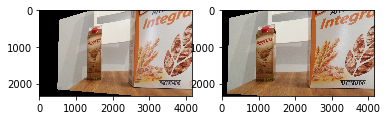

In [4]:
# ASSIGNMENT 1b
retval, h1, h2=cv2.stereoRectifyUncalibrated(np.asarray([points1]), np.asarray([points2]), FMatrix, (imagel.shape[0], imager.shape[1]))

imagel_trans=cv2.warpPerspective(imagel,h1,(imagel.shape[1],imagel.shape[0]))
plt.subplot(121)
plt.imshow(imagel_trans)

imager_trans=cv2.warpPerspective(imager,h2,(imagel.shape[1],imagel.shape[0]))
plt.subplot(122)
plt.imshow(imager_trans)


**<span style="color:red">ASSIGNMENT 1c -- </span>**

Now, plot the images side-by-side (i.e., concatenate them) and check that corresponding points fall in the same row! For that, just pick some points in the left image and draw a line on the same row in the right image.

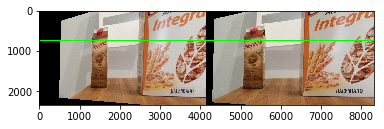

In [5]:
# ASSIGNMENT 1c
image_conc = np.concatenate((imagel_trans, imager_trans), axis=1)
point1 = (0, 750)
point2 = (10000, 750)

x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
image_conc = cv2.line(image_conc, point1, point2, (0, 255, 0), 25)

plt.imshow(image_conc)


**<span style="color:red">ASSIGNMENT 2 -- </span>**

Having the Fundamental matrix, **we can also calculate the epipolar lines** that correspond to any point, **even if the images are not rectified**. Remember that the Fundamental matrix encompasses the intrinsic geometric information between two views, regardless the scene!. The OpenCV's method [cv2.computeCorrespondEpilines](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga19e3401c94c44b47c229be6e51d158b7) facilitates this, having as inputs:

- `points`: set of $N$ input points of which corresponding epipolar lines will be computed
- `whichImage`: index of the image (1 for left or 2 for right) that contains the points
- `F`: the Fundamental matrix

It returns the **coefficients of the epipolar lines** in a ($N \times 1 \times 3$) matrix.

To show the epipolar lines, we have provided to you a method called `drawlines` (in utils) that plots the epilines in one image, and their corresponding keypoints (with the same color) in the other image, its inputs are:

- `im_points`: input image in which the points are going to be drawn
- `pts`: array containing the points' coordinates ($N \times 2$) of `im_points`
- `im_lines`: input image in which the epipolar lines are going to be drawn
- `lines`: coefficients of the epipolar lines drawn in `im_lines` 
- `size`: size of the elements drawn (default 5). Change this if you cannot see the lines and points or they are too big.

It returns two images, `im_lines` (with the lines superimposed) and `im_points` (where the points have been drawn).

**What to do?** Calculate the **epipolar lines of the keypoints previously detected in the right image**. Then, **draw the epipolar lines in the left image** and the points in the right one.

Finally, display both images.

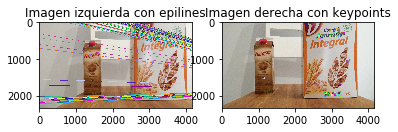

In [6]:
# ASSIGNMENT 2
# Write your code here!
lines=cv2.computeCorrespondEpilines(np.asarray([points2]), 2, FMatrix)

imagel_new, imager_new = drawlines(imager.copy(), np.asarray(points2, dtype = np.uint), imagel.copy(), lines, size = 5)

plt.subplot(1,2,1)
plt.title("Imagen izquierda con epilines")
plt.imshow(imagel_new)

plt.subplot(1,2,2)
plt.title("Imagen derecha con keypoints")
plt.imshow(imager_new)


## Conclusion

Brilliant! Note that if we had a fixed stereo system, **the Fundamental matrix would be constant for any pair of images**. Anyway, once rectification have been applied, triangulation is more precise, and so would be the depth computation!

In this notebook, we have learnt:

- the fundamentals of epipolar geometry
- how to perform stereo rectification for uncalibrated and calibrated cameras
- how to find the Fundamental matrix from a pair of images